# Complex Precoding LMMSE Pytorch Cooperation Quantized, 20.09.2022

In [1]:
import math
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp
from scipy.stats import gmean
from scipy.io import loadmat
from scipy.optimize import minimize, minimize_scalar, root
from scipy.optimize import NonlinearConstraint

from time import time
from glob import glob
from bisect import bisect
from functools import partial
from collections import defaultdict, deque
from sklearn.utils import resample
from statistics import mean, stdev
from tqdm.notebook import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(9.7,6.27)}, style="whitegrid", font_scale=1.2)

In [2]:
# H (n_users, n_layers, n_antennas)
# W (n_antennas, n_users, n_ranks)

In [3]:
beta_table = torch.tensor([[1.60, 1.60],
                  [1.61, 1.63],
                  [1.63, 1.67],
                  [1.65, 1.73],
                  [1.67, 1.79],
                  [1.70, 4.27],
                  [1.73, 4.71],
                  [1.76, 5.16],
                  [1.79, 5.66],
                  [1.82, 6.16],
                  [3.97, 6.50],
                  [4.27, 10.97],
                  [4.71, 12.92],
                  [5.16, 14.96],
                  [5.66, 17.06],
                  [6.16, 19.33],
                  [6.50, 21.85],
                  [9.95, 24.51],
                  [10.97, 27.14],
                  [12.92, 29.94],
                  [14.96, 56.48],
                  [17.06, 65.00],
                  [19.33, 78.58],
                  [21.85, 92.48],
                  [24.51, 106.27],
                  [27.14, 118.74],
                  [29.94, 126.36],
                  [32.05, 132.54]])

eff_sinr_table = torch.exp2(torch.tensor([(0.2344, 0.2344),
                                         (0.3066, 0.377),
                                         (0.377, 0.6016),
                                         (0.4902, 0.877),
                                         (0.6016, 1.1758),
                                         (0.7402, 1.4766),
                                         (0.877, 1.6953),
                                         (1.0273, 1.9141),
                                         (1.1758, 2.1602),
                                         (1.3262, 2.4063),
                                         (1.3281, 2.5703),
                                         (1.4766, 2.7305),
                                         (1.6953, 3.0293),
                                         (1.9141, 3.3223),
                                         (2.1602, 3.6094),
                                         (2.4063, 3.9023),
                                         (2.5703, 4.2129),
                                         (2.5703, 4.5234),
                                         (2.7305, 4.8164),
                                         (3.0293, 5.1152),
                                         (3.3223, 5.332),
                                         (3.6094, 5.5547),
                                         (3.9023, 5.8906),
                                         (4.2129, 6.2266),
                                         (4.5234, 6.5703),
                                         (4.8164, 6.9141),
                                         (5.1152, 7.1602),
                                         (5.332, 7.4063)])) - 1

#2.5664

In [4]:
def lin2db(x):
    """ Map linear scale to the logarithmic db """
    return 10 * np.log10(x)

def db2lin(x):
    """ Map logarithmic db to the linear scale """
    return 10 ** (x / 10)
    
def zero_forcing(V):
    """ Zero Forcing precoding in its native implementation """
    return V.solve(V @ V.conj().t())[0].conj().t()

def regularized(V, R):
    """ Regularization with inversed squared singular values """
    return V.solve(V @ V.conj().t() + V.shape[0] * torch.eye(V.shape[0]) * R)[0].conj().t()

def generalized_test(V, S, d, n):
    """ Generalization of regularized zero forcing with d-scaling """
    return (V * d).solve((V * d) @ V.conj().t() + V.shape[0] * ((n / S) ** 2).diag())[0].conj().t()

def generalized_old(V, d, n):
    """ Generalization of regularized zero forcing with d-scaling """
    return (V * d).solve((V * d) @ V.conj().t() + V.shape[0] * torch.eye(V.shape[0]) * n ** 2)[0].conj().t()

def generalized(V, d, n):
    """ Generalization of regularized zero forcing with d-scaling """
    return (V * d).solve((V * d) @ V.conj().t() + V.shape[0] * torch.eye(V.shape[0]) * n ** 2)[0].conj().t()

def normalize_precoding(W):
    """ Make feasible per antenna power with equalization """
    T = W / W.norm(dim=0)
    return T / T.norm(dim=1).max() / T.shape[0] ** 0.5

def normalize_max_antennas(W):
    """ Make feasible per antenna power with equalization """
    return W / W.norm(dim=1).max() / W.shape[0] ** 0.5

def equalize_users_antennas(W):
    T = W / W.norm(dim=0)
    return T / T.norm(dim=1, keepdim=True) / T.shape[0] ** 0.5

def equalize_antennas(W):
    return W / W.norm(dim=1, keepdim=True) / W.shape[0] ** 0.5

def equalize_users_antennas_numpy(W):
    T = W / np.linalg.norm(W, axis=0)
    return T / np.linalg.norm(T, axis=1, keepdims=True) / T.shape[0] ** 0.5

def equalize_antennas_outside(W):
    n = W.norm(dim=1, keepdim=True) * W.shape[0] ** 0.5
    return torch.where(n > 1, W / n, W)

# (W / n) * (n > 1) + W * (n <= 1)

def tgmean(input_x, dim):
    """ Differentiable Torch Geometric Mean """
    log_x = torch.log(input_x)
    return torch.exp(torch.mean(log_x, dim=dim))

def su_sinr(S, s):
    return lin2db(gmean(S.reshape(-1, n_ranks) ** 2, axis=1) / (n_ranks * s ** 2)).mean()

def spectral_efficiency(H, W, s):
    """ Score function is applied for torch complex tensors """
    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    K = B.permute(0, 2, 1).conj() @ B + torch.eye(B.shape[2]) * s ** 2
    
    G = B.permute(0, 2, 1).conj().solve(K)[0]
    G = torch.block_diag(*G)
    
    A = (G @ H.reshape(-1, n_antennas) @ W).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(dim=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().mean() * n_ranks

def irc_detection(H, W, s):
    """ IRC Detection Matrix """
    X = H.reshape(-1, n_antennas) @ W
    Y = X.reshape(n_users, n_layers, n_users, n_ranks)
    Z = Y.permute(0, 2, 1, 3) @ Y.permute(0, 2, 3, 1).conj()
    J = Z.permute(0, 2, 1, 3).reshape([n_users * n_layers] * 2)

    R = J.reshape(n_users, n_layers, n_users, n_layers).sum(dim=2)
    Q = torch.eye(R.shape[1]) * s ** 2

    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    G = B.solve(R + Q)[0].permute(0, 2, 1).conj()
    G = torch.block_diag(*G)
    return G, X

def spectral_efficiency_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().mean() * n_ranks

def mu_sinr_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return lin2db(L).mean()

def ideal_efficience(V, W, R):
    """ Score function is applied for torch complex tensors
            sum_k (log (sum_l |<v_k, w_l>|^2 + s^2) - 
                        log (sum_{l\k} |<v_k, w_l>|^2 + s^2)) 
    """
    A = V @ W
    B = (A * A.conj()).real
    N = B.sum(dim=1) + R
    D = N - B.diag()
    L = N.log2() - D.log2()
    return L.mean() * n_ranks

def quantize_precoding(W, N):
    def quantize(X, N):
        return (X / X.abs().max() * N).round()
    return torch.complex(quantize(W.real, N), quantize(W.imag, N))

def calc_corr(C):
    return ((np.abs(C @ C.conj().T) - np.eye(C.shape[0])) ** 2).mean()

def fbs_fame_loss(V, W, gamma=1.1):
    return (V @ W).norm() ** 2 - gamma * ((V.conj().t() * W).sum(dim=0).abs() ** 2).sum()

def fbs_fame_score(V, W, gamma=1.1):
    return gamma * ((V.conj().t() * W).sum(dim=0).abs() ** 2).sum() - (V @ W).norm() ** 2

def fbs_fame_prox(W, nu=1.1):
    def prox(X, eps, nu):
        return (nu * X).clamp(-eps, eps)
    eps = 1 / (2 * W.shape[0]) ** 0.5
    return torch.complex(prox(W.real, eps, nu), prox(W.imag, eps, nu))

def generate_channel(n_users, n_layers, n_antennas):
    """ Sample channel matrix H from the complex normal distribution CN(0, I) """
    return np.random.randn(n_users, n_layers, n_antennas, 2).view(complex).squeeze() / 2 ** 0.5

# Algorithms

In [5]:
from collections.abc import Sequence

class FlyingSuSinr(Sequence):
    def __init__(self, S, s_grid):
        """Construct a lazy sequence representation"""
        self.s_grid = s_grid
        self.n = len(self.s_grid)
        self.sinr = partial(su_sinr, S)
    def __len__(self):
        return self.n
    def __getitem__(self, i):
        if not (0 <= i < self.n):
            raise IndexError
        return self.sinr(self.s_grid[i])

In [6]:
from torch.optim import LBFGS, Adam

def equalized(V, s, n_iter=1):
    """ Equalization for antenna powers using generalized least squares """
    W = regularized(V, s)
    d = torch.ones(V.shape[1])
    for _ in range(n_iter):
        W /= W.norm(dim=0)
        d /= W.norm(dim=1)
        d /= d.norm()
        W = generalized(V, d, s)
    return W

def diagonal_regularizer_solver(V, R, s):
    x = torch.full([V.shape[0]], s, requires_grad=True)
    optim = LBFGS([x], max_iter=100, line_search_fn="strong_wolfe")
    def closure():
        W = normalize_precoding(regularized(V, x))
        func = -ideal_efficience(V, W, R)
        optim.zero_grad()
        func.backward()
        return func
    
    optim.step(closure)
    return x.detach()

def diagonal_power_solver(V, R, s):
    x = torch.ones(V.shape[1], requires_grad=True)
    optim = LBFGS([x], max_iter=100, line_search_fn="strong_wolfe")
    flag = False
    def closure():
        global flag
        W = normalize_precoding(generalized(V, x, s))
        #if (x < 0).any():
        #    print("Inner step", x)
        #    f = True
        func = -ideal_efficience(V, W, R)
        optim.zero_grad()
        func.backward()
        return func
    optim.step(closure)
    #print("The last step", x)
    return x.detach()

def diagonal_power_solver_singularized(V, S, R, s):
    x = torch.ones(V.shape[1], requires_grad=True)
    optim = LBFGS([x], max_iter=100, line_search_fn="strong_wolfe")
    def closure():
        W = normalize_precoding(generalized_test(V, S, x, s))
        func = -ideal_efficience(V, W, R)
        optim.zero_grad()
        func.backward()
        return func

    optim.step(closure)
    return x.detach()

def diagonal_common_solver(V, R, s):
    x = torch.full([V.shape[0]], s, requires_grad=True)
    y = torch.ones(V.shape[1], requires_grad=True)
    optim = LBFGS([x, y], max_iter=100, line_search_fn="strong_wolfe")
    def closure():
        W = normalize_precoding(generalized(V, y, x))
        func = -ideal_efficience(V, W, R)
        optim.zero_grad()
        func.backward()
        return func
    
    optim.step(closure)
    return x.detach(), y.detach()

def ideal_lbfgs_solver(W, V, R, ls="strong_wolfe"):
    params = [W.real.requires_grad_(), W.imag.requires_grad_()]
    optim = LBFGS(params, max_iter=100, line_search_fn=ls)
    def closure():
        W = torch.complex(*params)
        P = equalize_antennas_outside(W)
        func = -ideal_efficience(V, P, R)
        optim.zero_grad()
        func.backward()
        return func

    optim.step(closure)
    return torch.complex(*params).detach()

def common_lbfgs_solver(W, H, s):
    params = [W.real.requires_grad_(), W.imag.requires_grad_()]
    optim = LBFGS(params, max_iter=100, line_search_fn="strong_wolfe")
    def closure():
        W = torch.complex(*params)
        P = equalize_antennas_outside(W)
        func = -spectral_efficiency_irc(H, P, s)
        optim.zero_grad()
        func.backward()
        return func
    
    optim.step(closure)
    return torch.complex(*params).detach()

def pebf_lbfgs_solver(W, H, s):
    params = [W.real.requires_grad_(), W.imag.requires_grad_()]
    optim = LBFGS(params, max_iter=40, line_search_fn="strong_wolfe")
    def closure():
        W = torch.complex(*params)
        P = normalize_max_antennas(W)
        func = -spectral_efficiency_irc(H, P, s)
        optim.zero_grad()
        func.backward()
        return func
    
    optim.step(closure)
    return torch.complex(*params).detach()

def parameterized_lbfgs_solver(W, H, s):
    theta = W.abs().log().requires_grad_()
    eta = ((W.angle() + math.pi) / 2 / math.pi).logit().requires_grad_()
    alpha = W.norm(dim=1).logit().unsqueeze(dim=1)
    optim = LBFGS([theta, eta, alpha], max_iter=64, line_search_fn="strong_wolfe")

    def precoding():
        rho = (theta.softmax(dim=1) * alpha.sigmoid() / theta.shape[0]) ** 0.5
        phi = 2 * math.pi * eta.sigmoid()
        W = rho * (phi * 1j).exp()
        return W
    
    def closure():
        func = -spectral_efficiency(H, precoding(), s)
        optim.zero_grad()
        func.backward(retain_graph=True)
        return func
    
    optim.step(closure)
    return precoding().detach()

def check_zf(V, W):
    x = np.abs(V @ W)
    d = x.diag().sum()
    s = x.sum()
    return d / (s - d)

In [7]:
def find_mcses(sinr_eff, qam_mode):
    x = sinr_eff >= eff_sinr_table[:, qam_mode, np.newaxis]
    x[0, :] = torch.ones(1, sinr_eff.shape[0], dtype=bool)
    return torch.nonzero(torch.diff(x, 
        append=torch.zeros(1, sinr_eff.shape[0], dtype=bool), dim=0))[:, 0]

def spectral_efficiency_irc_qam(H, W, s, qam_mode=0):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    
    sinr = ((N / D) - 1).reshape(-1, n_ranks)  
    sinr_eff = tgmean(sinr, dim=-1)
    
    mcses = find_mcses(sinr_eff, qam_mode)
    for _ in range(3):
        x = -sinr / beta_table[mcses, qam_mode][:, None]
        sinr_eff = -beta_table[mcses, qam_mode] * (x.logsumexp(dim=1) - math.log(x.shape[1]))
        mcses = find_mcses(sinr_eff, qam_mode)
    
    return (1 + sinr_eff).log2().mean() * n_ranks


def beta_table_irc_qam(H, W, s, qam_mode=0):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()

    sinr = ((N / D) - 1).reshape(-1, n_ranks)
    sinr_eff = tgmean(sinr, dim=-1)
                 
    mcses = find_mcses(sinr_eff, qam_mode)
    for _ in range(3):
        x = -sinr / beta_table[mcses, qam_mode][:, None]
        sinr_eff = -beta_table[mcses, qam_mode] * (x.logsumexp(dim=1) - math.log(x.shape[1]))
        mcses = find_mcses(sinr_eff, qam_mode)
       
    return beta_table[mcses, qam_mode]

def layer_mu_sinr_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = N / D - 1
    #L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return lin2db(L)#.mean()

In [8]:
def intersection_power_method(A, P):
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    P2 = 1 / B
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    return P3.sqrt()

def intersection_power_method_old(A, P, R, H, W, s, qam_mode):
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    C = R * B
    # R = (s / S) ** 2

    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = (C.log() -  C.mean().log()) * b
    P2 = (((Y * C).sum() + 1 / n_antennas) / C.sum() - Y) * R
    
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        return P.sqrt()
    else:
        return P3.sqrt()
    
def intersection_power_method_new(A, P, R, H, W, s, qam_mode):
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    C = R * B
    # R = (s / S) ** 2

    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = torch.repeat_interleave(C.reshape(n_users, n_ranks).mean(dim=1), n_ranks)
    F = (C.log() -  C.mean().log()) * b + 1
    P2 = (((F * C).mean() + 1 / (n_antennas * n_ranks * n_users) ) / Y - F) * R

    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        print("Hello!")
        return P.sqrt()
    else:
        return P3.sqrt()

def intersection_power_method_old_irc(A, P, H, W, s, qam_mode):
    G, X = irc_detection(H, W, s)
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    K = (G.abs() ** 2).sum(axis=1) * s ** 2
    C = K * B
        
    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = (C.log() -  C.mean().log()) * b
    P2 = (((Y * C).sum() + 1 / n_antennas) / C.sum() - Y) * K
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        print("Hello!")
        return P.sqrt()
    else:
        return P3.sqrt()
    
def intersection_power_method_new_irc(A, P, H, W, s, qam_mode):
    G, X = irc_detection(H, W, s)  
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    K = (G.abs() ** 2).sum(axis=1) * s ** 2
    C = K * B
        
    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = torch.repeat_interleave(C.reshape(n_users, n_ranks).mean(dim=1), n_ranks)
    F = (C.log() -  C.mean().log()) * b + 1  
    P2 = (((F * C).mean() + 1 / (n_antennas * n_ranks * n_users) ) / Y - F) * K
    
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        print("Hello!")
        return P.sqrt()
    else:
        return P3.sqrt()
    
def layer_power_solver(A, P):
    optim = LBFGS([P.requires_grad_()], line_search_fn="strong_wolfe")
    def closure():
        func = (A @ P).max().log() - P.log().sum() + P.mean()
        optim.zero_grad()
        func.backward()
        return func
    optim.step(closure)
    return P.detach()

def lagrange_power_method(A, P, R, N):
    for i in range(N):
        B = A[(A @ P).argmax(), :]
        P = 1 / (R + B / P.mean())
    return P

In [9]:
#precise_gradient_descent(W_RG.clone(), V, R, verbose=True);

In [10]:
path = "save_data/n_users=8/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/coeff.2.mat"

In [13]:
ls "save_data/n_users=8/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/"

coeff.1.mat   coeff.26.mat  coeff.36.mat  coeff.3.mat   coeff.7.mat
coeff.24.mat  coeff.2.mat   coeff.38.mat  coeff.40.mat  coeff.9.mat


# Tests

In [14]:
H = loadmat(path)["coeff"][..., -1]
n_users, n_layers, n_antennas = H.shape # Global constants
S, V = np.linalg.svd(H, full_matrices=False)[1:]
S_max = S[:, 0].max()
H /= S_max; S /= S_max
qam_mode = 0

target_sinr = 40
s_grid = np.logspace(1, -5, num=200)
n_antennas, n_ranks = 64, 2

In [15]:
H.shape

(4, 4, 64)

In [16]:
V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
S = torch.from_numpy(S[:, :n_ranks].flatten())
H = torch.from_numpy(H)

In [17]:
flying_sinr = FlyingSuSinr(S, s_grid)
s = s_grid[bisect(flying_sinr, target_sinr)]
s

0.0027682866303920667

In [18]:
W_ZF = normalize_precoding(zero_forcing(V))
print("ZF")
print((1 / W_ZF.norm(dim=0)))

ZF
tensor([4.9741, 4.9741, 4.9741, 4.9741, 4.9741, 4.9741, 4.9741, 4.9741],
       dtype=torch.float64)


<ipython-input-4-67f0ec6c967b>:11: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811740025/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return V.solve(V @ V.conj().t())[0].conj().t()


In [19]:
A = (W_ZF * W_ZF.conj()).real
P = (1 / W_ZF.norm(dim=0))
P.sum(), P

(tensor(39.7928, dtype=torch.float64),
 tensor([4.9741, 4.9741, 4.9741, 4.9741, 4.9741, 4.9741, 4.9741, 4.9741],
        dtype=torch.float64))

In [20]:
sinr_zf = layer_mu_sinr_irc(H, W_ZF, s) #* layer_mu_sinr_irc(H, W_ZF, s).max()
sinr_zf.mean()

tensor(24.9795, dtype=torch.float64)

tensor(25.3313, dtype=torch.float64)

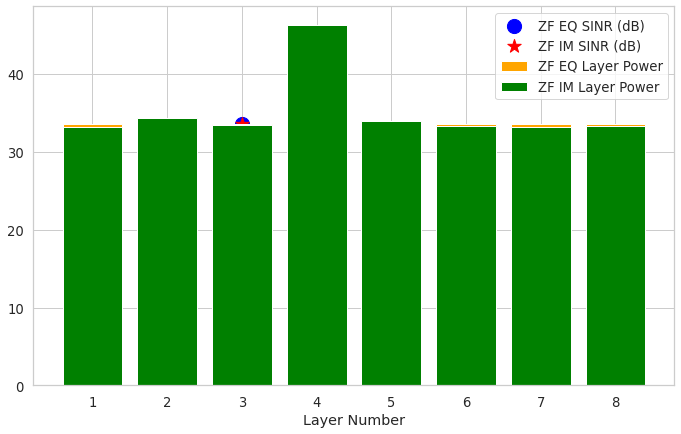

In [21]:
P = intersection_power_method(A, P)
W_IM = normalize_max_antennas(W_ZF * P)
sinr_im = layer_mu_sinr_irc(H, W_IM, s) #* layer_mu_sinr_irc(H, W_ZF, s).max()


plt.bar(np.arange(W_IM.shape[1]) + 1, W_ZF.norm(dim=0) / W_ZF.norm(dim=0) * layer_mu_sinr_irc(H, W_ZF, s).max(), alpha=1, color="orange", label="ZF EQ Layer Power")
plt.bar(np.arange(W_IM.shape[1]) + 1, W_IM.norm(dim=0) / W_ZF.norm(dim=0) * layer_mu_sinr_irc(H, W_ZF, s).max(), color='green', label="ZF IM Layer Power")
plt.scatter(np.arange(W_IM.shape[1]) + 1, sinr_zf, s=200, color="blue", label="ZF EQ SINR (dB)")
plt.scatter(np.arange(W_IM.shape[1]) + 1, sinr_im, s=200, marker='*', color="red", label="ZF IM SINR (dB)")

#plt.ylabel("Layer Power Ratio")
plt.xlabel("Layer Number")
plt.legend()
plt.tight_layout()


#plt.savefig("Images/power_distr_im_method_2.pdf")


# Ratio of amplification compared to equal power distribution 
sinr_im.mean()

Hello!


tensor(12.2129, dtype=torch.float64)

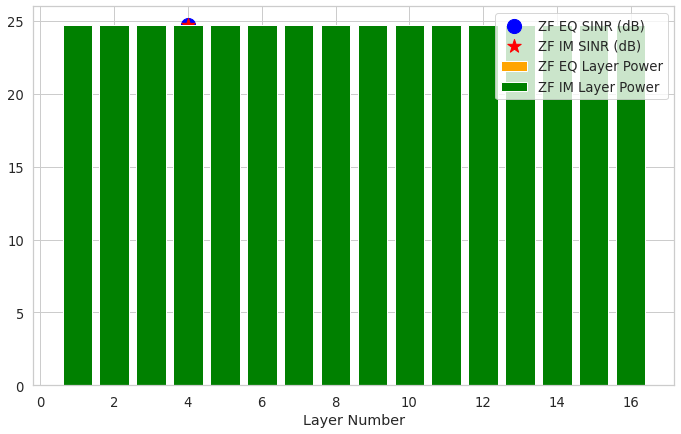

In [20]:
A = (W_ZF * W_ZF.conj()).real
P = (1 / W_ZF.norm(dim=0))
P.sum(), P

P = intersection_power_method_new_irc(A, P, H, W_ZF, s, qam_mode)
W_IM = normalize_max_antennas(W_ZF * P)
sinr_im = layer_mu_sinr_irc(H, W_IM, s) #* layer_mu_sinr_irc(H, W_ZF, s).max()
sinr_zf = layer_mu_sinr_irc(H, W_ZF, s) #* layer_mu_sinr_irc(H, W_ZF, s).max()

plt.bar(np.arange(W_IM.shape[1]) + 1, W_ZF.norm(dim=0) / W_ZF.norm(dim=0) * layer_mu_sinr_irc(H, W_ZF, s).max(), alpha=1, color="orange", label="ZF EQ Layer Power")
plt.bar(np.arange(W_IM.shape[1]) + 1, W_IM.norm(dim=0) / W_ZF.norm(dim=0) * layer_mu_sinr_irc(H, W_ZF, s).max(), color='green', label="ZF IM Layer Power")
plt.scatter(np.arange(W_IM.shape[1]) + 1, sinr_zf, s=200, color="blue", label="ZF EQ SINR (dB)")
plt.scatter(np.arange(W_IM.shape[1]) + 1, sinr_im, s=200, marker='*', color="red", label="ZF IM SINR (dB)")

#plt.ylabel("Layer Power Ratio")
plt.xlabel("Layer Number")
plt.legend()
plt.tight_layout()


#plt.savefig("Images/power_distr_im_method_2.pdf")


# Ratio of amplification compared to equal power distribution 
sinr_im.mean()

In [21]:
W = W_ZF
qam_mode = 0

In [22]:
X = H.reshape(-1, n_antennas) @ W
Y = X.reshape(n_users, n_layers, n_users, n_ranks)
Z = Y.permute(0, 2, 1, 3) @ Y.permute(0, 2, 3, 1).conj()
J = Z.permute(0, 2, 1, 3).reshape([n_users * n_layers] * 2)

R = J.reshape(n_users, n_layers, n_users, n_layers).sum(dim=2)
Q = torch.eye(R.shape[1]) * s ** 2

B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
G = B.solve(R + Q)[0].permute(0, 2, 1).conj()
G = torch.block_diag(*G)

A = (G @ X).abs() ** 2
N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
D = N - A.diag()

sinr = ((N / D) - 1).reshape(-1, n_ranks)
sinr_eff = tgmean(sinr, dim=-1)

mcses = find_mcses(sinr_eff, qam_mode)
for _ in range(2):
    print(mcses)
    x = -sinr / beta_table[mcses, qam_mode][:, None]
    sinr_eff = -beta_table[mcses, qam_mode] * (x.logsumexp(dim=1) - math.log(x.shape[1]))
    mcses = find_mcses(sinr_eff, qam_mode)

tensor([14, 14, 21, 22, 22, 24, 24, 27])
tensor([14, 15, 21, 22, 23, 24, 24, 27])


# Massive Experiments

In [23]:
history = defaultdict(list)
n_ranks = 2
#full_path = "save_data/n_users=8/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/*"
full_path = "save_data/n_users=8/3GPP_38.901_UMa_NLOS/**/*.mat"

for i, path in enumerate(glob(full_path, recursive=True)):
    H = loadmat(path)["coeff"][..., -1]
    S, V = np.linalg.svd(H, full_matrices=False)[1:]
    history["Correlation"].append(calc_corr(V[:, 0, :]))
round(mean(history["Correlation"]), 3), round(stdev(history["Correlation"]), 3)

(0.078, 0.036)

In [25]:
full_path = "save_data/n_users=8/3GPP_38.901_UMa_NLOS/**/*.mat"
len(glob(full_path, recursive=True))

40

In [26]:
list(next(enumerate(glob(full_path, recursive=True))))

[0,
 'save_data/n_users=8/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/coeff.22.mat']

In [27]:
# def calc_corr(A, B):
#     return (np.abs(np.corrcoef(A.conj().T, B)) ** 2).mean()

history, times = defaultdict(list), defaultdict(list)
s_grid = np.logspace(1, -10, num=2000)
n_antennas, n_ranks = 64, 2
n_iters, mantissa = 2, 4
#full_path = "save_data/n_users=4/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/*"
full_path = "save_data/n_users=4/3GPP_38.901_UMa_NLOS/**/*.mat"
#full_path = "save_data/n_users=4/3GPP_38.901_UMa_NLOS/close_users/urban/correlated_users/coeff.1.mat"

for target_sinr in tqdm(range(8, 43, 3)):
    for i, path in enumerate(glob(full_path, recursive=True)):
        H = loadmat(path)["coeff"][..., -1]
#         H[0] *= 5
#         H[1] *= 2
#         H[2] /= 2
#         H[3] /= 5
#         H[4] /= 2
#         H[5] /= 5
#         H[6] /= 7
#         H[7] /= 10

        H[0] *= 5
        H[1] *= 2
        H[2] /= 2
        H[3] /= 5
        
        n_users, n_layers, n_antennas = H.shape # Global constants
        S, V = np.linalg.svd(H, full_matrices=False)[1:]
        S_max = S[:, 0].max()
        H /= S_max; S /= S_max
        
#        history["Correlation"].append(calc_corr(V[:, 0, :]))
        
        V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
        S = torch.from_numpy(S[:, :n_ranks].flatten())
        H = torch.from_numpy(H)

        flying_sinr = FlyingSuSinr(S, s_grid)
        s = s_grid[bisect(flying_sinr, target_sinr)]

        R = (s / S) ** 2
        #R = 1
        alpha = db2lin(-su_sinr(S, s))
        scale = n_users * n_ranks

        Q = ((1 / S) ** 2).reshape(n_users, n_ranks)
        
#         'Regularized Zero-Forcing',
#        'Single Step Optimization', 'Double Step Optimization',
#        'Quazi-Newton Converged'
        
#         start = time()
#         W_MR = normalize_precoding(V.conj().t())
#         times["MRT"].append(time() - start)
#         history["MRT"].append(float(spectral_efficiency_irc(H, W_MR, s)))
        
        W_ZF = normalize_max_antennas(zero_forcing(V))
        print("ZF")
        print("Primal", W_ZF.norm(dim=0))
        print("Inv", 1 / W_ZF.norm(dim=0) / (1 / W_ZF.norm(dim=0)).max())
        history["ZF"].append(float(spectral_efficiency_irc(H, W_ZF, s)))
    
#         A = (W_ZF * W_ZF.conj()).real
#         P = (1 / W_ZF.norm(dim=0))
#         P = intersection_power_method(A, P)
#         W_IM = normalize_max_antennas(W_ZF * P)
#         history["ZF IM RAW"].append(float(spectral_efficiency_irc(H, W_IM, s)))
        
        #W_ZF = normalize_max_antennas(zero_forcing(V))
        print("ZF Table 1")
        history["ZF Table 1"].append(float(spectral_efficiency_irc_qam(H, W_ZF, s, 0)))
        
        #W_ZF = normalize_max_antennas(zero_forcing(V))
        print("ZF Table 2")
        history["ZF Table 2"].append(float(spectral_efficiency_irc_qam(H, W_ZF, s, 1)))
        
#         A = (W_ZF * W_ZF.conj()).real
#         P = (1 / W_ZF.norm(dim=0))
#         P = intersection_power_method(A, P)
#         W_IM = normalize_max_antennas(W_ZF * P)
#         history["ZF IM RAW MCS"].append(float(ideal_efficiene(V, W_IM, R)))
        
        W_ZF = normalize_precoding(zero_forcing(V))
        print("ZF EQ")
        history["ZF EQ"].append(float(spectral_efficiency_irc(H, W_ZF, s)))
        
        W_ZF = normalize_precoding(zero_forcing(V))
        print("ZF EQ Table 1")
        history["ZF EQ Table 1"].append(float(spectral_efficiency_irc_qam(H, W_ZF, s, 0)))
        
        W_ZF = normalize_precoding(zero_forcing(V))
        print("ZF EQ Table 2")
        history["ZF EQ Table 2"].append(float(spectral_efficiency_irc_qam(H, W_ZF, s, 1)))
        
        # POWER ALLOCATION METHODS
        
#         W_ZF = normalize_precoding(zero_forcing(V))
#         P = (Q / Q.sum(dim=1, keepdim=True)).flatten() ** 0.5
#         W_ZN = normalize_max_antennas(W_ZF * P) 
#         history["ZF ZN"].append(float(spectral_efficiency_irc(H, W_ZN, s)))
        
#         W_ZF = normalize_precoding(zero_forcing(V))
#         P = (Q / Q.sum(dim=1, keepdim=True)).flatten() ** 0.5
#         W_ZN = normalize_max_antennas(W_ZF * P) 
#         history["ZF ZN Table 1"].append(float(spectral_efficiency_irc_qam(H, W_ZN, s, 0)))
        
#         W_ZF = normalize_precoding(zero_forcing(V))
#         P = (Q / Q.sum(dim=1, keepdim=True)).flatten() ** 0.5
#         W_ZN = normalize_max_antennas(W_ZF * P) 
#         history["ZF ZN Table 2"].append(float(spectral_efficiency_irc_qam(H, W_ZN, s, 1)))
        
        W_ZF = zero_forcing(V)   
        A = (W_ZF * W_ZF.conj()).real
        P = (1 / W_ZF.norm(dim=0))
        P = intersection_power_method(A, P)
        W_IM = normalize_max_antennas(W_ZF * P)
        print("ZF IM CD")
        print(P / P.max())
        history["ZF IM CD"].append(float(spectral_efficiency_irc(H, W_IM, s)))
        
        W_ZF = zero_forcing(V)
        A = (W_ZF * W_ZF.conj()).real
        P = (1 / W_ZF.norm(dim=0))
        P = intersection_power_method(A, P)
        W_IM = normalize_max_antennas(W_ZF * P)
        print("ZF IM CD Table 1")
        print(P / P.max())
        history["ZF IM CD Table 1"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 0)))
        
        W_ZF = zero_forcing(V)
        A = (W_ZF * W_ZF.conj()).real
        P = (1 / W_ZF.norm(dim=0))
        P = intersection_power_method(A, P)
        W_IM = normalize_max_antennas(W_ZF * P)
        print("ZF IM CD Table 2")
        print(P / P.max())
        history["ZF IM CD Table 2"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 1)))
        
#         A = (W_ZF * W_ZF.conj()).real
#         P = (1 / W_ZF.norm(dim=0))
#         P = intersection_power_method_new(A, P, R)
#         W_IM = normalize_max_antennas(W_ZF * P)
#         history["ZF IM MCS "].append(float(spectral_efficiency_irc(H, W_IM, s)))
        
        A = (W_ZF * W_ZF.conj()).real
        P = (1 / W_ZF.norm(dim=0))
        P = intersection_power_method_new(A, P, R, H, W_ZF, s, 0)
        W_IM = normalize_max_antennas(W_ZF * P)
        print("ZF IM MCS CD Table 1")
        print(P / P.max())
        history["ZF IM MCS CD Table 1"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 0)))
        
        A = (W_ZF * W_ZF.conj()).real
        P = (1 / W_ZF.norm(dim=0))
        P = intersection_power_method_new(A, P, R, H, W_ZF, s, 1)
        W_IM = normalize_max_antennas(W_ZF * P)
        print("ZF IM MCS CD Table 2")
        print(P / P.max())
        history["ZF IM MCS CD Table 2"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 1)))
        
        A = (W_ZF * W_ZF.conj()).real
        P = (1 / W_ZF.norm(dim=0))
        P = intersection_power_method_new_irc(A, P, H, W_ZF, s, 0)
        W_IM = normalize_max_antennas(W_ZF * P)
        print("ZF IM MCS IRC Table 1")
        print(P / P.max())
        history["ZF IM MCS IRC Table 1"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 0)))
        
        A = (W_ZF * W_ZF.conj()).real
        P = (1 / W_ZF.norm(dim=0))
        P = intersection_power_method_new_irc(A, P, H, W_ZF, s, 1)
        W_IM = normalize_max_antennas(W_ZF * P)
        print("ZF IM MCS IRC Table 2")
        print(P / P.max())
        history["ZF IM MCS IRC Table 2"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 1)))


        history["SU SINR"].append(target_sinr)
        times["SU SINR"].append(target_sinr)

  0%|          | 0/12 [00:00<?, ?it/s]

In [36]:
[(len(history[k]), k) for k in history.keys()]

[(480, 'ZF'),
 (480, 'ZF Table 1'),
 (480, 'ZF Table 2'),
 (480, 'ZF EQ'),
 (480, 'ZF EQ Table 1'),
 (480, 'ZF EQ Table 2'),
 (480, 'ZF IM CD'),
 (480, 'ZF IM CD Table 1'),
 (480, 'ZF IM CD Table 2'),
 (480, 'ZF IM MCS CD Table 1'),
 (480, 'ZF IM MCS CD Table 2'),
 (480, 'ZF IM MCS IRC Table 1'),
 (480, 'ZF IM MCS IRC Table 2'),
 (480, 'SU SINR')]

In [37]:
history = pd.DataFrame(history)

In [38]:
#np.mean(history['Correlation'])

In [39]:
#np.std(history['Correlation'])

In [40]:
history = pd.DataFrame(history)
#history.drop(columns="Correlation", inplace=True)
history_min = history.groupby("SU SINR").min()
history_mean = history.groupby("SU SINR").mean()
history_std = history.groupby("SU SINR").std()

scenario_name = '_'.join(full_path.split('/')[1:-1])
scenario_name = scenario_name.replace("=", "_")
scenario_name

'n_users_4_3GPP_38.901_UMa_NLOS_**'

In [41]:
lin2db(2 ** (history_mean / n_ranks) - 1)

,ZF,ZF Table 1,ZF Table 2,ZF EQ,ZF EQ Table 1,ZF EQ Table 2,ZF IM CD,ZF IM CD Table 1,ZF IM CD Table 2,ZF IM MCS CD Table 1,ZF IM MCS CD Table 2,ZF IM MCS IRC Table 1,ZF IM MCS IRC Table 2
SU SINR,,,,,,,,,,,,,
8,0.697514,0.261924,0.261893,1.112186,0.674365,0.672420,1.446378,0.962295,0.956127,0.997975,1.067143,1.067985,1.104742
11,2.742503,2.141094,2.139995,3.149755,2.586234,2.575823,3.484546,2.867143,2.858218,2.931897,2.900795,2.974076,2.998651
14,4.794488,4.057844,4.055832,5.202803,4.539113,4.537459,5.543471,4.823701,4.821429,4.894121,4.867977,4.903394,4.898304
17,6.873889,6.065301,6.049820,7.291016,6.582523,6.569110,7.642239,6.888873,6.867090,6.942983,6.929383,6.969970,6.955981
20,9.054264,8.237189,8.234206,9.486632,8.774017,8.772075,9.852068,9.098077,9.090737,9.139878,9.136665,9.170510,9.166607
23,11.348994,10.540072,10.532992,11.800613,11.098975,11.103984,12.182436,11.436573,11.447712,11.463917,11.466783,11.493325,11.495231
26,13.779682,12.978061,12.994908,14.251811,13.558555,13.589837,14.650961,13.903918,13.956420,13.923381,13.955115,13.939820,13.972752
29,16.326618,15.502520,15.552881,16.818763,16.092231,16.162136,17.235063,16.438494,16.536039,16.455064,16.525675,16.455198,16.525926
32,19.022103,18.133327,18.245167,19.533434,18.738236,18.872358,19.965484,19.085403,19.263196,19.099956,19.235924,19.100028,19.236126


In [42]:
history_mean.index.name = "SU SINR (dB)"

In [43]:
s ** 2

5.430845322709165e-07

In [44]:
((s / S) ** 2)

tensor([5.4308e-07, 2.1172e-06, 6.8375e-06, 1.4429e-05, 8.1036e-05, 2.6996e-04,
        8.4211e-04, 2.6247e-03], dtype=torch.float64)

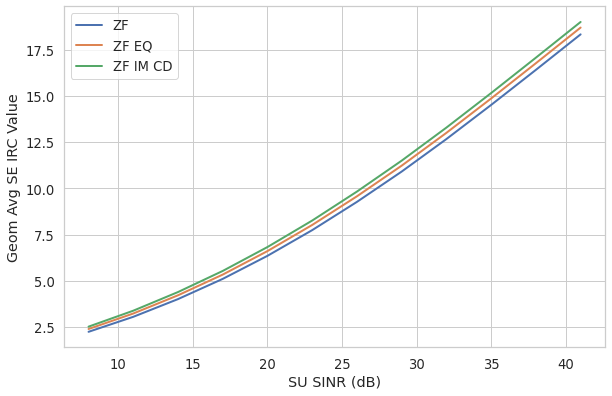

In [46]:
history_mean[["ZF", "ZF EQ", 'ZF IM CD']].plot(lw=2, ylabel="Geom Avg SE IRC Value")
plt.savefig("Images/PA_SE_IRC_Native.pdf", bbox_inches='tight')

<ipython-input-47-ab2a02af266b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


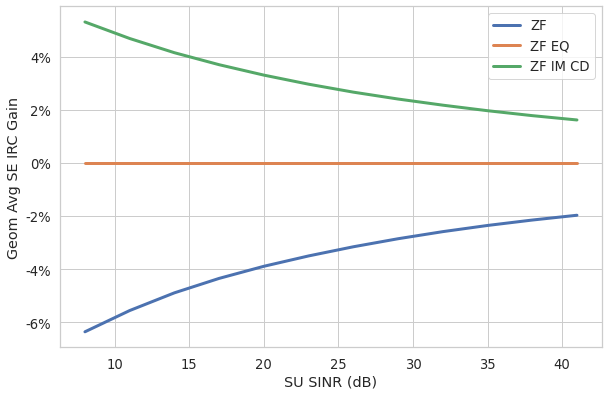

In [47]:
ax = ((history_mean[["ZF", "ZF EQ", 'ZF IM CD']] / history_mean["ZF EQ"].values[:, None] - 1)).plot(lw=3, ylabel="Geom Avg SE IRC Gain")
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.savefig("Images/PA_SE_IRC.pdf", bbox_inches='tight')

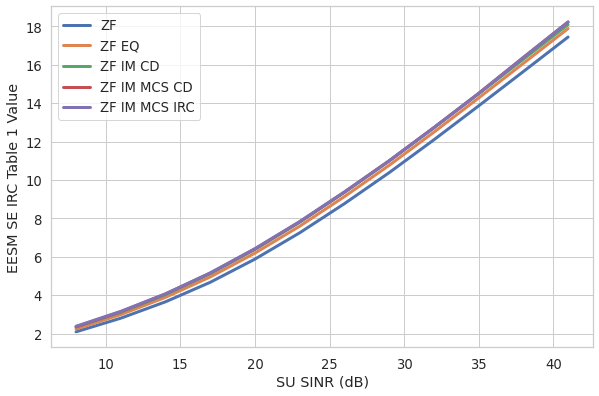

In [48]:
history_mean[["ZF Table 1", "ZF EQ Table 1", 'ZF IM CD Table 1', "ZF IM MCS CD Table 1", "ZF IM MCS IRC Table 1"]].rename(columns={"ZF Table 1":"ZF", "ZF EQ Table 1":"ZF EQ", 'ZF IM CD Table 1':"ZF IM CD",
                             "ZF IM MCS CD Table 1":"ZF IM MCS CD", "ZF IM MCS IRC Table 1":"ZF IM MCS IRC"}).plot(lw=3, ylabel="EESM SE IRC Table 1 Value")
# manipulate
plt.savefig("Images/PA_SE_Table_1_IRC_Native.pdf", bbox_inches='tight')

<ipython-input-49-c858e841672c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


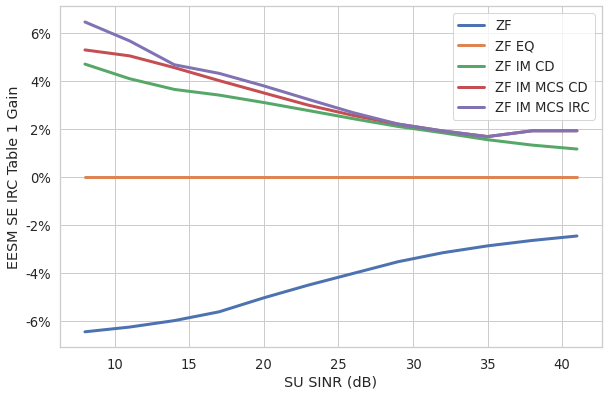

In [49]:
ax = ((history_mean[["ZF Table 1", "ZF EQ Table 1", 'ZF IM CD Table 1', "ZF IM MCS CD Table 1", "ZF IM MCS IRC Table 1"]].rename(columns={"ZF Table 1":"ZF", "ZF EQ Table 1":"ZF EQ", 'ZF IM CD Table 1':"ZF IM CD",
                             "ZF IM MCS CD Table 1":"ZF IM MCS CD", "ZF IM MCS IRC Table 1":"ZF IM MCS IRC"}) / history_mean["ZF EQ Table 1"].values[:, None] - 1)).plot(lw=3, ylabel="EESM SE IRC Table 1 Gain")
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.savefig("Images/PA_SE_Table_1_IRC.pdf", bbox_inches='tight')

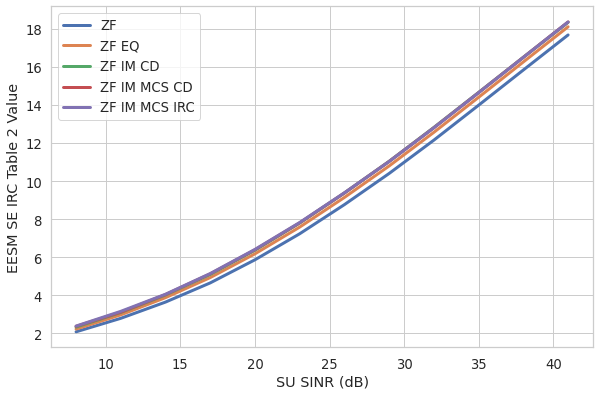

In [50]:
history_mean[["ZF Table 2", "ZF EQ Table 2", 'ZF IM CD Table 2', "ZF IM MCS CD Table 2", "ZF IM MCS IRC Table 2"]].rename(columns={"ZF Table 2":"ZF", "ZF EQ Table 2":"ZF EQ", 'ZF IM CD Table 2':"ZF IM CD",
                             "ZF IM MCS CD Table 2":"ZF IM MCS CD", "ZF IM MCS IRC Table 2":"ZF IM MCS IRC"}).plot(lw=3, ylabel="EESM SE IRC Table 2 Value")
# manipulate
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.savefig("Images/PA_SE_Table_2_IRC_Native.pdf", bbox_inches='tight')

<ipython-input-51-26cd81e05fe2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


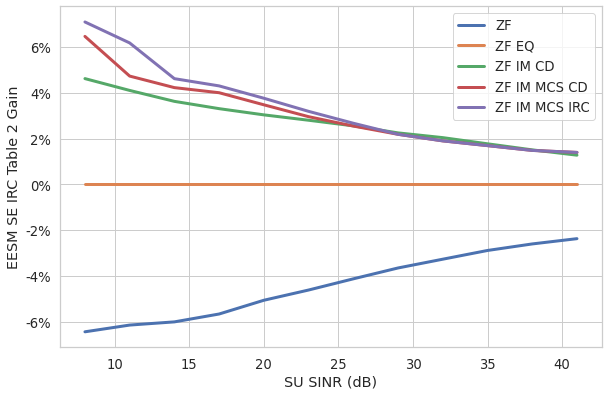

In [51]:
ax = ((history_mean[["ZF Table 2", "ZF EQ Table 2", 'ZF IM CD Table 2', "ZF IM MCS CD Table 2", "ZF IM MCS IRC Table 2"]].rename(columns={"ZF Table 2":"ZF", "ZF EQ Table 2":"ZF EQ", 'ZF IM CD Table 2':"ZF IM CD",
                             "ZF IM MCS CD Table 2":"ZF IM MCS CD", "ZF IM MCS IRC Table 2":"ZF IM MCS IRC"}) / history_mean["ZF EQ Table 2"].values[:, None] - 1)).plot(lw=3, ylabel="EESM SE IRC Table 2 Gain")
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.savefig("Images/PA_SE_Table_2_IRC.pdf", bbox_inches='tight')